In [1]:
import torch
import torch.nn as nn

import numpy as np

from torch.utils.data import DataLoader
from torchsummary import summary

from pathlib import Path
from dataset.segment import Guide3D

from tqdm import tqdm

In [4]:
class InvertedResidualBlock(nn.Module):
    """
    inverted residual block used in MobileNetV2
    """
    def __init__(self, in_c, out_c, stride, expansion_factor=6, deconvolve=False):
        super(InvertedResidualBlock, self).__init__()
        # check stride value
        assert stride in [1, 2]
        self.stride = stride
        self.in_c = in_c
        self.out_c = out_c
        # Skip connection if stride is 1
        self.use_skip_connection = True if self.stride == 1 else False

        # expansion factor or t as mentioned in the paper
        ex_c = int(self.in_c * expansion_factor)
        if deconvolve:
            self.conv = nn.Sequential(
                # pointwise convolution
                nn.Conv2d(self.in_c, ex_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # depthwise convolution
                nn.ConvTranspose2d(ex_c, ex_c, 4,self.stride,1, groups=ex_c, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # pointwise convolution
                nn.Conv2d(ex_c, self.out_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(self.out_c),
            )
        else:
            self.conv = nn.Sequential(
                # pointwise convolution
                nn.Conv2d(self.in_c, ex_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # depthwise convolution
                nn.Conv2d(ex_c, ex_c, 3, self.stride, 1, groups=ex_c, bias=False),
                nn.BatchNorm2d(ex_c),
                nn.ReLU6(inplace=True),
                # pointwise convolution
                nn.Conv2d(ex_c, self.out_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(self.out_c),
            )
        self.conv1x1 = nn.Conv2d(self.in_c, self.out_c, 1, 1, 0, bias=False)

            

    def forward(self, x):
        if self.use_skip_connection:
            out = self.conv(x)
            if self.in_c != self.out_c:
                x = self.conv1x1(x)
            return x+out
        else:
            return self.conv(x)


class MobileUNet(nn.Module):
    """
    Modified UNet with inverted residual block and depthwise seperable convolution
    """

    def __init__(self):
        super(MobileUNet, self).__init__()

        # encoding arm
        self.conv3x3 = self.depthwise_conv(3, 32, p=1, s=2)
        self.irb_bottleneck1 = self.irb_bottleneck(32, 16, 1, 1, 1)
        self.irb_bottleneck2 = self.irb_bottleneck(16, 24, 2, 2, 6)
        self.irb_bottleneck3 = self.irb_bottleneck(24, 32, 3, 2, 6)
        self.irb_bottleneck4 = self.irb_bottleneck(32, 64, 4, 2, 6)
        self.irb_bottleneck5 = self.irb_bottleneck(64, 96, 3, 1, 6)
        self.irb_bottleneck6 = self.irb_bottleneck(96, 160, 3, 2, 6)
        self.irb_bottleneck7 = self.irb_bottleneck(160, 320, 1, 1, 6)
        self.conv1x1_encode = nn.Conv2d(320, 1280, kernel_size=1, stride=1)
        # decoding arm
        self.D_irb1 = self.irb_bottleneck(1280, 96, 1, 2, 6, True)
        self.D_irb2 = self.irb_bottleneck(96, 32, 1, 2, 6, True)
        self.D_irb3 = self.irb_bottleneck(32, 24, 1, 2, 6, True)
        self.D_irb4 = self.irb_bottleneck(24, 16, 1, 2, 6, True)
        self.DConv4x4 = nn.ConvTranspose2d(16,16,4,2,1,groups=16, bias=False)
        # Final layer: output channel number can be changed as per the usecase
        self.conv1x1_decode = nn.Conv2d(16, 2, kernel_size=1, stride=1)

    def depthwise_conv(self, in_c, out_c, k=3, s=1, p=0):
        """
        optimized convolution by combining depthwise convolution and
        pointwise convolution.
        """
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=k, padding=p, groups=in_c, stride=s),
            nn.BatchNorm2d(num_features=in_c),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_c, out_c, kernel_size=1),
        )
        return conv
    
    def irb_bottleneck(self, in_c, out_c, n, s, t, d=False):
        """
        create a series of inverted residual blocks.
        """
        convs = []
        xx = InvertedResidualBlock(in_c, out_c, s, t, deconvolve=d)
        convs.append(xx)
        if n>1:
            for i in range(1,n):
                xx = InvertedResidualBlock(out_c, out_c, 1, t, deconvolve=d)
                convs.append(xx)
        conv = nn.Sequential(*convs)
        return conv
    
    def get_count(self, model):
        # simple function to get the count of parameters in a model.
        num = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return num
    
    def forward(self, x):
        # Left arm/ Encoding arm
        #D1
        x1 = self.conv3x3(x) #(32, 112, 112)
        x2 = self.irb_bottleneck1(x1) #(16,112,112) s1
        x3 = self.irb_bottleneck2(x2) #(24,56,56) s2
        x4 = self.irb_bottleneck3(x3) #(32,28,28) s3
        x5 = self.irb_bottleneck4(x4) #(64,14,14)
        x6 = self.irb_bottleneck5(x5) #(96,14,14) s4
        x7 = self.irb_bottleneck6(x6) #(160,7,7)
        x8 = self.irb_bottleneck7(x7) #(320,7,7)
        x9 = self.conv1x1_encode(x8) #(1280,7,7) s5

        # Right arm / Decoding arm with skip connections
        d1 = self.D_irb1(x9) + x6
        d2 = self.D_irb2(d1) + x4
        d3 = self.D_irb3(d2) + x3
        d4 = self.D_irb4(d3) + x2
        d5 = self.DConv4x4(d4)
        out = self.conv1x1_decode(d5)
        return out         

In [7]:
ROOT_PATH = Path("../guide3d/data/annotations/guide3d")
model = MobileUNet().to("cuda")

ds = Guide3D(ROOT_PATH)
dl = DataLoader(ds, batch_size = 4, shuffle = True)

# summary(model, (3, 1024, 1024))

NameError: name 'MobileUNet' is not defined

In [3]:
TOTAL_EPOCHS = 25
loss_f = nn.CrossEntropyLoss().to("cuda")
optimiser = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser,T_max = 15)

losses = np.array([])

warnings.filterwarnings(action='once')
with torch.set_grad_enabled(True):
    torch.cuda.empty_cache()

    for curr_epoch in tqdm(range(1, TOTAL_EPOCHS + 1)):
        curr_epoch_losses = np.array([])
        optimiser.zero_grad()

        for imgs_batch in dl:
            imgs = np.stack((imgs_batch[0],) * 3, axis = -1).reshape(4, 3, 1024, 1024)
            imgs = torch.tensor(imgs, dtype = torch.float).to("cuda")
            segms = torch.tensor(imgs_batch[1], dtype = torch.long).to("cuda")

            Y_preds = model(imgs)
            loss = loss_f(Y_preds, segms)

            loss.backward()
            optimiser.step()
            scheduler.step()

            curr_epoch_losses = np.append(curr_epoch_losses, loss.cpu().detach())

        losses = np.append(losses, np.mean(curr_epoch_losses))

NameError: name 'model' is not defined

In [5]:
model = MobileUNet()
model.load_state_dict(torch.load("trained_mobileunet_sd_43_epochs.pth"))

<All keys matched successfully>

0.0 1.0
torch.Size([1, 2, 1024, 1024])


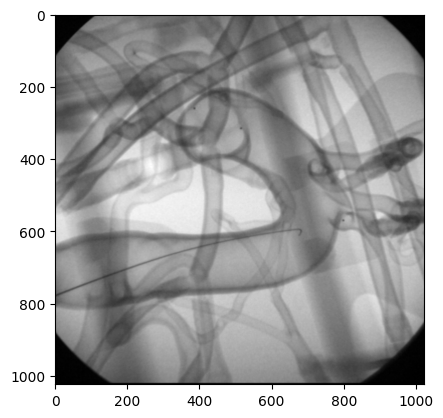

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

model.eval()
model = model.to("cuda")

size = 1024, 1024

test_img = Image.open("./TestImg.png").convert('L')

test_img = test_img.resize(size)
test_img = np.array(test_img, np.float32)

test_img = np.transpose(np.stack((test_img,) * 3, axis = -1)).reshape(1, 3, 1024, 1024)
plt.imshow(test_img[0, 0, :, :], cmap = "gray")

test_img = (test_img - test_img.min())/(test_img.max() - test_img.min())

print(np.min(test_img), np.max(test_img))

test_img = torch.tensor(test_img).reshape(1, 3, 1024, 1024).to("cuda")

Y_preds = model(test_img).cpu().detach()
print(Y_preds.shape)

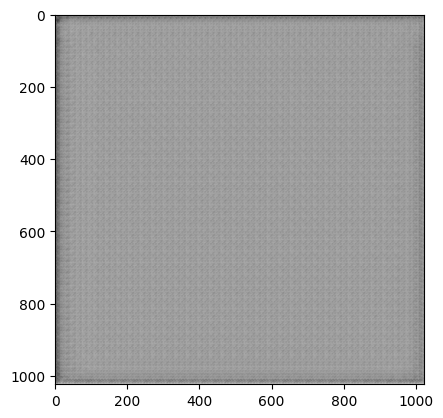

In [17]:
Y = torch.sigmoid(Y_preds).cpu().detach().numpy()*100

plt.imshow(Y[0, 0, :, :], cmap = "gray")

In [18]:
Y[0, 1, :, :]

array([[0.3292461 , 0.5731735 , 0.39169532, ..., 0.5040239 , 0.3659426 ,
        0.5649302 ],
       [0.3812992 , 0.58853215, 0.5915719 , ..., 0.5315275 , 0.48351637,
        0.39321655],
       [0.37065977, 0.6144332 , 0.5327296 , ..., 0.47081044, 0.43522742,
        0.6410648 ],
       ...,
       [0.3565728 , 0.5693317 , 0.6341992 , ..., 0.41829547, 0.47708532,
        0.3573907 ],
       [0.33912978, 0.6539188 , 0.54066765, ..., 0.4150087 , 0.43944097,
        0.61069643],
       [0.31525284, 0.5025735 , 0.47157323, ..., 0.4298361 , 0.34249932,
        0.30080515]], dtype=float32)